In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the MNIST dataset.
It has the classes of hand written digits:. The images in MNIST are of
size 1x28x28 (In pytorch we put channel dimension in the first place.), i.e. gray level images of 28x28 pixels in size.


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





## 1. Loading and normalizing MNIST


Using ``torchvision``, it’s extremely easy to load MNIST.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

We need to normalize images before starting. Normally intensity values of MNIST dataset are in [0,255]. The output of torchvision datasets are PILImage images of range [0, 1]. So we do not need to normalize them here. However it is always good to check the values before starting the training.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])#,
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Processing...
Done!


Let us see some of the training images.

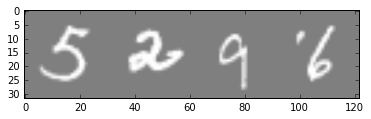

    5     2     9     6


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 if you want, you can play with images by checking values shape etc.

In [5]:
#images.shape

## 2. Define a Convolutional Neural Network


Please first check the [pytorch.nn](https://pytorch.org/docs/stable/nn.html) document in order to understand methods and how to use them.



In [6]:
import torch.nn as nn
import torch.nn.functional as F

use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

if use_gpu:
    net = net.cuda()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum. (Please check [pytorch.nn](https://pytorch.org/docs/stable/nn.html) document for them).

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize. If you want, also you can check the training time by using  ``time`` module in python.

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.388
[1,  4000] loss: 0.366
[1,  6000] loss: 0.207
[1,  8000] loss: 0.162
[1, 10000] loss: 0.140
[1, 12000] loss: 0.113
[1, 14000] loss: 0.114
[2,  2000] loss: 0.082
[2,  4000] loss: 0.089
[2,  6000] loss: 0.076
[2,  8000] loss: 0.077
[2, 10000] loss: 0.076
[2, 12000] loss: 0.069
[2, 14000] loss: 0.073
Finished Training


## 5. Test the network on the test data 
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

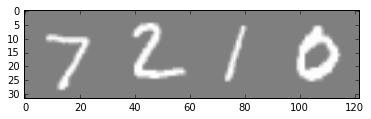

GroundTruth:      7     2     1     0


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:

In [10]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:      7     2     1     0


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


That looks waaay better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 96 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 96 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %


### Questions (optional)

1. Can you try with different batch sizes? What do you notice?
2. You can play with knobs (# of epochs, layers, filters, padding etc.) and see the effects of each. Later, you can try to get better result.
3. You can easily check which classes are confused with each other by using ``sklearn confusion matrix``

It is cool, isn't it? It is just the beginning. You can go deeper at home.

## 6. Fashion MNIST (optional)
If you like CNN, you can play with this dataset.

## 7. References
Pytorch.org